# Developing a State-of-the-Art Interpreter Model for Sign Language Communication
Contributors: Shubham Khandale, Allen Lau, Sumaiya Uddin

Source Code: https://github.com/DataScienceAndEngineering/machine-learning-dse-i210-final-project-signlanguageclassification.git

Project Workspace Setup: Run /src/data/make_dataset.py to download necessary data to execute this notebook.

Table of Contents:
1. [Source Code](#code)
2. [Abstract](#abstract)
3. [Introduction](#introduction)
4. [Background](#background)
5. [Data](#data)
6. [Methods](#methods)
7. [Evaluation](#evaluation)
8. [Conclusion](#conclusion)
9. [Attribution](#attribution)
10. [Bibliography](#bibliography)
11. [Appendix](#appendix)


## Source Code <a class="anchor" id="code"></a>

In [1]:
#importing libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_sign_minist(path):
    """
    function for loading the sign language mnist dataset pickle file, generated from /src/data/make_dataset.py
    
    Args:
        path (str): path to sign_mnist.pkl

    Returns:
        tuple: X_train,y_train,X_test,y_test
    """
    with open(path,'rb') as f:
        data = pickle.load(f)
    return data

In [3]:
def get_label_dict(y):
    """
    Function to return a dictionary of numeric labels to letters 

    Args:
        y (numpy array): numpy array of labels

    Returns:
        dict: {label:letter} 
    """
    #letters
    letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
    #numbers 
    y = pd.Series(y,dtype=int)
    numbers = sorted(list(y.unique()))
    #dictionary of labels 
    return dict(zip(numbers,letters))

In [4]:
def find_indices(data,label):
    """
    fuction to find the indices given a label 

    Args:
        data (numpy array or pandas series): image data 
        label (int): label

    Raises:
        Exception: If not pandas series or numpy array 

    Returns:
        _type_: indices of specific label
    """
    #check if data is numpy array
    if type(data) == np.ndarray:
        #return indices
        return np.where(data==label)
    #check if data is pandas series 
    elif type(data) == pd.Series:
        #return indices
        return data[data==label].index
    #else not supported in this function
    else:
        raise Exception('Not supported data type for this function.')
        

In [5]:
def visualize_data(x,y,labels_dict):
    #visualization of dataset 
    fig, ax = plt.subplots(4,6)
    ax = ax.ravel()
    pos = 0 
    #loop through each label in dataset 
    for label in range(0,26):
        #if label is not included in dataset 
        if label in [9,25]:
            continue
        #find first index of label
        idx = find_indices(y,label)[0][0]
        #display first found image 
        ax[pos].imshow(x[idx],cmap='gray')
        #set x label as dataset label
        ax[pos].set(xlabel=labels_dict[label])
        #do not show ticks 
        ax[pos].set_xticks([])
        ax[pos].set_yticks([])
        #increment for subplotting 
        pos+=1
    plt.suptitle('Fig. 1: Sign Language Dataset')
    plt.close()
    return fig

In [33]:
def var_img(x):
    fig, ax = plt.subplots(1, 2)
    ax = ax.ravel()

    x = x.reshape(x.shape[0], -1)
    mean_img = np.mean(x, axis=0)
    var_img = np.var(x, axis=0)

    ax[0].imshow(mean_img.reshape(28, 28), cmap='gray')
    ax[0].set_title('Mean Image')

    ax[1].imshow(var_img.reshape(28, 28), cmap='gray')
    ax[1].set_title('Variance Image')

    plt.tight_layout()
    plt.show()
    return fig


## Abstract <a class="anchor" id="abstract"></a>

Clear and effective communication is a vital component of society. However, for individuals who rely on sign language, interacting with those who are unfamiliar with this mode of communication can be a difficult task. The development of a model capable of receiving a video stream from a camera and accurately classifying the signed letters can prove to be an invaluable tool. This technology can be utilized in various settings, including hospitals, schools, and government offices, to facilitate seamless communication and eliminate any potential communication barriers.

**INSERT INFO ON WHAT WAS ACCOMPLISHED**

## Introduction <a class="anchor" id="introduction"></a>

## Background <a class="anchor" id="background"></a>

## Data <a class="anchor" id="data"></a>

The Sign Language MNIST dataset ([Kaggle](https://www.kaggle.com/datasets/datamunge/sign-language-mnist))  will be used for developing the Sign Language Interpreter model. It is structured as a CSV format with rows containing flattened images of pixel intensity values and its associated letter label. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z, which require motion and will not be explored in this project). The training data (27,455 instances) and test data (7172 cases) are around half the size of the standard MNIST but otherwise identical, with a header row of label, pixel1, pixel2,...pixel784 representing a single 28x28 pixel image with grayscale values ranging from 0-255.

In [29]:
#load dataset
X_train,y_train,X_test,y_test = load_sign_minist('../data/external/sign_mnist.pkl')

#get labels dictionary
label_dict = get_label_dict(y_train)

#printing shapes
print(f'X_train shape:{X_train.shape}')
print(f'y_train shape:{y_train.shape}')
print(f'X_test shape:{X_test.shape}')
print(f'y_test shape:{y_test.shape}')

#printing label
print(label_dict)

X_train shape:(27455, 28, 28)
y_train shape:(27455,)
X_test shape:(7172, 28, 28)
y_test shape:(7172,)
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}


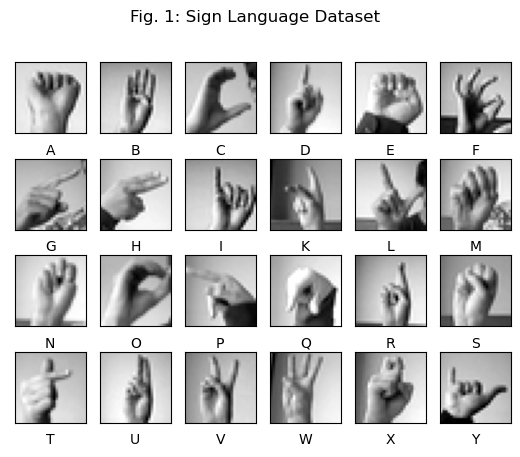

In [10]:
#visualizing examples from the data set
fig = visualize_data(X_train,y_train,label_dict)
fig

Fig. 1 displays example images for each letter in the dataset, where the hands are generally centered with white backgrounds.

## EDA

we can look how image will looks like for each class if we average it. for that we can take avegare valuse of each pixel across all observation.

To take the average image for each class, we can group the training data by label and then calculate the mean of each pixel across all observations with the same label.

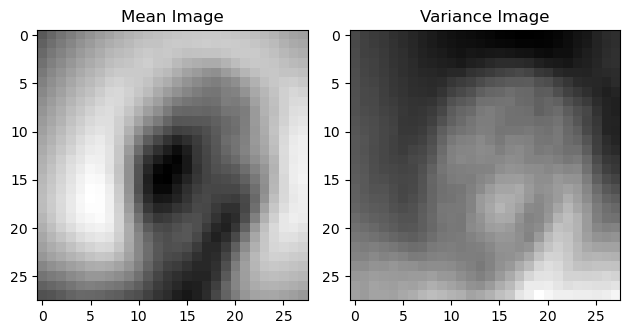

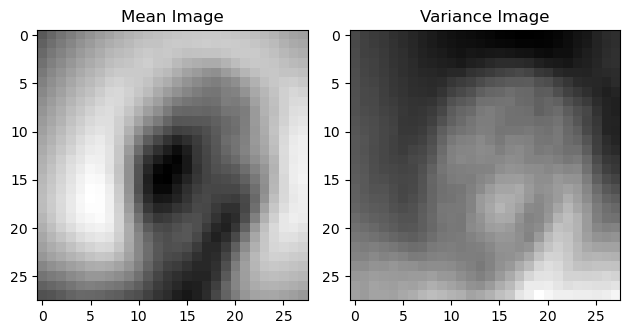

In [35]:
#Plotting mean and varience image
var_img(X_train)

## Methods <a class="anchor" id="methods"></a>

Feature selection
* LDA 
* PCA of HOG


* Show Best ML Model
* Show Deep Learning 
* Show Best Deep Learning Model 

## Evaluation <a class="anchor" id="evaluation"></a>

## Attribution <a class="anchor" id="attribution"></a>

## Bibliography <a class="anchor" id="bibliography"></a>

## Appendix <a class="anchor" id="appendix"></a>

Feature Selection
* UMAP, SVD, TSNE

Main Model Results not with combined features